<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/XGBoost-4/Instacart_2017_XGBoost_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Mounted at /content/drive/
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [3]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
# orders = pd.read_csv("orders_50.csv")
# order_products_prior = pd.read_csv("op_prior_50.csv")
# order_products_train = pd.read_csv("op_train_50.csv")
orders = pd.read_csv("orders_100.csv")
order_products_prior = pd.read_csv("op_prior_100.csv")
order_products_train = pd.read_csv("op_train_100.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (1665732, 7)
products:  (49688, 4)
order_products_prior:  (15806241, 4)
order_products_train:  (672294, 4)


Reducing size of orders for faster computation

In [4]:
# orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 
orders.shape

(1665732, 7)

In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Changing some columns from object type to Category

In [6]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [7]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (15806241, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [8]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15806241 entries, 0 to 15806240
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int64   
 5   order_hour_of_day       int64   
 6   days_since_prior_order  float64 
 7   product_id              int64   
 8   add_to_cart_order       int64   
 9   reordered               int64   
dtypes: category(1), float64(1), int64(8)
memory usage: 1.2 GB


In [9]:
op['reordered'] = op['reordered'].astype('int8')
op['order_dow'] = op['order_dow'].astype('int8')
op['order_hour_of_day'] = op['order_hour_of_day'].astype('int8')
op['add_to_cart_order'] = op['add_to_cart_order'].astype('int8')
op['days_since_prior_order'] = op['days_since_prior_order'].astype('float16')

In [10]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15806241 entries, 0 to 15806240
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
 7   product_id              int64   
 8   add_to_cart_order       int8    
 9   reordered               int8    
dtypes: category(1), float16(1), int64(4), int8(4)
memory usage: 708.5 MB


1. USER PREDICTORS




In [11]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (99999, 1)
total users in the prior dataset = 99999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [12]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [13]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (99999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [14]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (99999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [15]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49096, 2)


,product_id,p_total_purchases
0,1,919
1,2,58
2,3,149
3,4,158
4,5,2


In [16]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (13952977, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [17]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (7936, 2)


,product_id,p_reorder_ratio
0,1,0.610446
1,10,0.516541
2,23,0.440882
3,25,0.641077
4,28,0.462236


In [18]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49096, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,1,919,0.610446
1,2,58,NaN
2,3,149,NaN
3,4,158,NaN
4,5,2,NaN


In [19]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,919,0.610446
1,2,58,0.000000
2,3,149,0.000000
3,4,158,0.000000
4,5,2,0.000000


3. USER-PRODUCT PREDICTORS

In [20]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       196                       10
        10258                      9
        10326                      1
        12427                     10
        13032                      3

In [21]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6479328, 3)


,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [22]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (6479328, 1)


Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [23]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (99999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [24]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (6479328, 3)


,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [25]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (6479328, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [26]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (6479328, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [27]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6479328, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [28]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [29]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6479328, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [30]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [31]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6479328, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


MERGE ALL FEATURES

In [32]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6479328, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915
3,1,12427,10,1.000000,10,0.694915
4,1,13032,3,0.333333,10,0.694915


In [33]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6479328, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,17589,0.778384
1,1,10258,9,1.000000,10,0.694915,865,0.702890
2,1,10326,1,0.166667,10,0.694915,2743,0.656945
3,1,12427,10,1.000000,10,0.694915,3092,0.736740
4,1,13032,3,0.333333,10,0.694915,1670,0.636527


In [34]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

52

TRAIN DF

In [35]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (1665732, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [36]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (15806241, 10)


,user_id,product_id,reordered
0,1,196,0
1,1,14084,0
2,1,12427,0
3,1,26088,0
4,1,26405,0
5,1,196,1
6,1,10258,0
7,1,12427,1
8,1,13176,0
9,1,26088,1


In [37]:
op = op.groupby(['user_id','product_id'])['reordered'].sum()

op = op.reset_index()
# op3 = op3[op3['new_reorder'] > 0]

# new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
op['reordered'] = op['reordered'].apply(lambda x: 0 if x == 0 else 1)
op.head(20)
op.shape

(6479328, 3)

In [38]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (6479328, 9)


In [39]:
del op

In [40]:
opjoin.head(40)

,user_id,product_id,reordered,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,1,10,1.000000,10,0.694915,17589,0.778384
1,1,10258,1,9,1.000000,10,0.694915,865,0.702890
2,1,10326,0,1,0.166667,10,0.694915,2743,0.656945
3,1,12427,1,10,1.000000,10,0.694915,3092,0.736740
4,1,13032,1,3,0.333333,10,0.694915,1670,0.636527
5,1,13176,1,2,0.222222,10,0.694915,184594,0.832709
6,1,14084,0,1,0.100000,10,0.694915,7973,0.810235
7,1,17122,0,1,0.166667,10,0.694915,6464,0.667543
8,1,25133,1,8,1.000000,10,0.694915,3003,0.732268
9,1,26088,1,2,0.200000,10,0.694915,1260,0.538889


In [41]:
opjoin['reordered'].unique()

array([1, 0])

In [42]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head()

reordered  uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                                   
1       196                 1                10           1.000000   
        10258               1                 9           1.000000   
        10326               0                 1           0.166667   
        12427               1                10           1.000000   
        13032               1                 3           0.333333   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
1       196                     10           0.694915              17589   
        10258                   10           0.694915                865   
        10326                   10           0.694915               2743   
        12427                   10           0.694915               3092   
        13032                   10           0.694915               1670   

                    p_reorder_ratio  
user_id product_id                   
1       196                0.778384  
        10258              0.702890  
        10326              0.656945  
        12427              0.736740  
        13032              0.636527

In [43]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6479328 entries, (1, 196) to (99999, 49174)
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   reordered          int64  
 1   uxp_total_bought   int64  
 2   uxp_reorder_ratio  float64
 3   u_total_orders     int64  
 4   u_reordered_ratio  float64
 5   p_total_purchases  int64  
 6   p_reorder_ratio    float64
dtypes: float64(3), int64(4)
memory usage: 399.6 MB


TEST DF 

In [44]:
order_products_train = order_products_train[order_products_train['reordered']==1]

op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

op_test.shape (403449, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [45]:
op_test = op_test.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [46]:
op_test[op_test['user_id']==1]

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [47]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (403449, 3)


,user_id,product_id,expected_y
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1


In [48]:
opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin_test.shape =', opjoin_test.shape)

opjoin_test.shape = (403449, 9)


In [49]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head(12)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,17589,0.778384
1,1,25133,8,1.000000,10,0.694915,3003,0.732268
2,1,38928,1,1.000000,10,0.694915,6256,0.821132
3,1,26405,2,0.200000,10,0.694915,544,0.411765
4,1,39657,1,1.000000,10,0.694915,2424,0.768564
5,1,10258,9,1.000000,10,0.694915,865,0.702890
6,1,13032,3,0.333333,10,0.694915,1670,0.636527
7,1,26088,2,0.200000,10,0.694915,1260,0.538889
8,1,49235,2,0.666667,10,0.694915,35576,0.776113
9,1,46149,3,1.000000,10,0.694915,4188,0.815186


In [50]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
1       196                       10                1.0              10   
        25133                      8                1.0              10   
        38928                      1                1.0              10   
        26405                      2                0.2              10   
        39657                      1                1.0              10   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  
user_id product_id                                                         
1       196                  0.694915              17589         0.778384  
        25133                0.694915               3003         0.732268  
        38928                0.694915               6256         0.821132  
        26405                0.694915                544         0.411765  
        39657                0.694915               2424         0.768564

Build Model

In [51]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [52]:
opjoin.head()

reordered  uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                                   
1       196                 1                10           1.000000   
        10258               1                 9           1.000000   
        10326               0                 1           0.166667   
        12427               1                10           1.000000   
        13032               1                 3           0.333333   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
1       196                     10           0.694915              17589   
        10258                   10           0.694915                865   
        10326                   10           0.694915               2743   
        12427                   10           0.694915               3092   
        13032                   10           0.694915               1670   

                    p_reorder_ratio  
user_id product_id                   
1       196                0.778384  
        10258              0.702890  
        10326              0.656945  
        12427              0.736740  
        13032              0.636527

In [53]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[06:45:54] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.614875
[10]	train-logloss:0.189977
[20]	train-logloss:0.074326
[30]	train-logloss:0.030558
[40]	train-logloss:0.012874
[50]	train-logloss:0.005088
[60]	train-logloss:0.00202
[70]	train-logloss:0.000808
[79]	train-logloss:0.000361


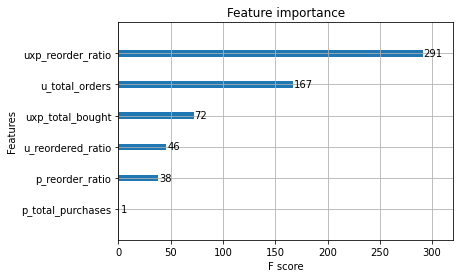

In [54]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [55]:
del [X_train, X_val, y_train, y_val]
gc.collect()

87

In [56]:
opjoin_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
1       196                       10                1.0              10   
        25133                      8                1.0              10   
        38928                      1                1.0              10   
        26405                      2                0.2              10   
        39657                      1                1.0              10   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  
user_id product_id                                                         
1       196                  0.694915              17589         0.778384  
        25133                0.694915               3003         0.732268  
        38928                0.694915               6256         0.821132  
        26405                0.694915                544         0.411765  
        39657                0.694915               2424         0.768564

In [57]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,196,1,1
1,25133,1,1
2,38928,1,0
3,26405,1,1
4,39657,1,0
...,...,...,...
403444,37646,99999,1
403445,14221,99999,1
403446,38383,99999,1
403447,6970,99999,1


In [58]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,0,1
3,26405,1,1,1
4,39657,1,0,1


In [59]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,0,1
3,26405,1,1,1
4,39657,1,0,1
5,10258,1,1,1
6,13032,1,1,1
7,26088,1,1,1
8,49235,1,1,1
9,46149,1,1,1


In [60]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,0,1,False
3,26405,1,1,1,True
4,39657,1,0,1,False


In [61]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403449 entries, 0 to 403448
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   product_id           403449 non-null  int64
 1   user_id              403449 non-null  int64
 2   reordered_predicted  403449 non-null  int64
 3   expected_y           403449 non-null  int64
 4   compare              403449 non-null  bool 
dtypes: bool(1), int64(4)
memory usage: 15.8 MB


In [62]:
true_count = tally['compare'].sum()
true_count

287688

In [63]:
false_count = len(tally['compare'])
false_count

403449

In [64]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 71.30715406408244 %


In [65]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,0,1,False
3,26405,1,1,1,True
4,39657,1,0,1,False
5,10258,1,1,1,True
6,13032,1,1,1,True
7,26088,1,1,1,True
8,49235,1,1,1,True
9,46149,1,1,1,True
